# Content Analysis

In [129]:
import arviz as az
import bambi as bmb
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [130]:
df = pd.read_json('year_predictions.json')
df['image_id'] = np.random.permutation(len(df))

# adding paths
df2 = pd.read_json('image_data.json')
df['paths'] = df2[0]

# calculating error rate
df['error_bw'] = df['actual_year'] - df['year_pred']
df['error_bw_abs'] = df['error_bw'].abs()


<Axes: title={'center': 'distribution of absolute error'}, ylabel='Frequency'>

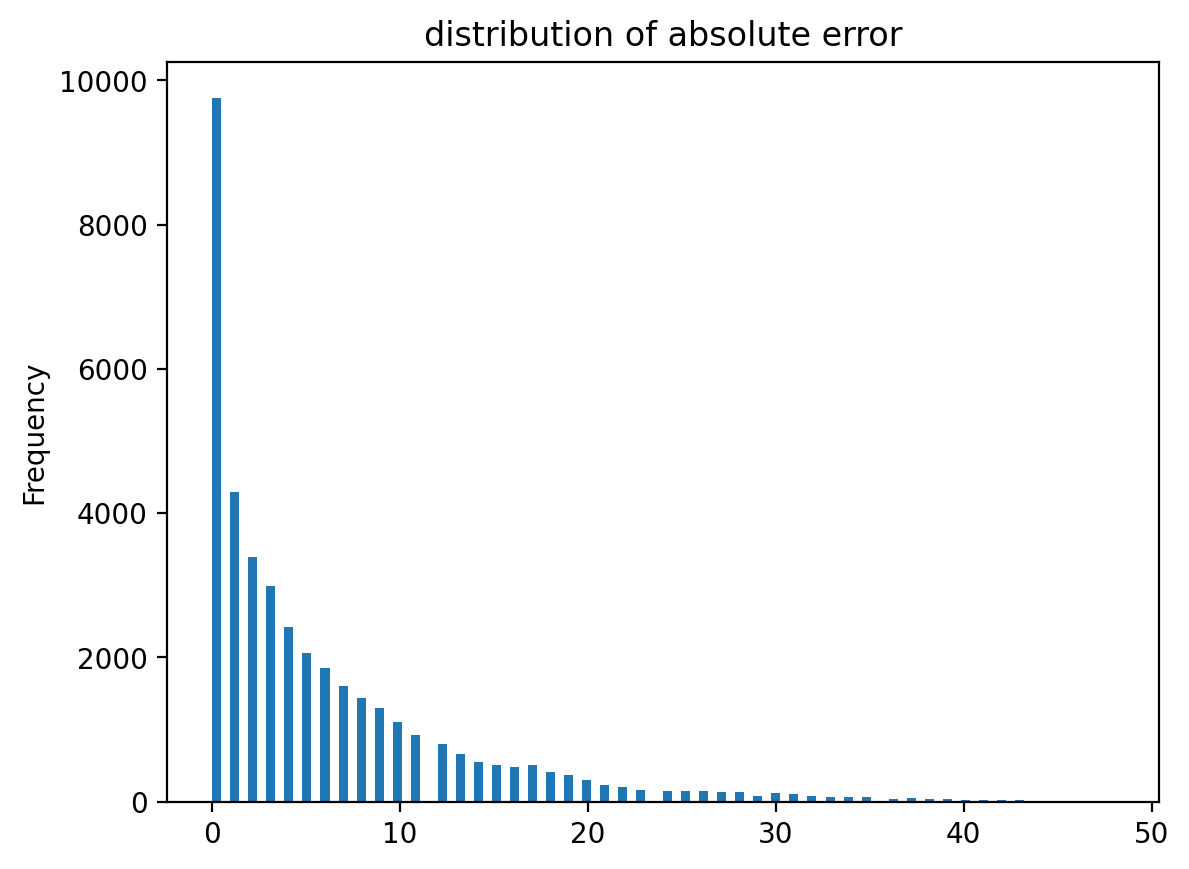

In [134]:
df['error_bw_abs'].plot.hist(bins=100, title='distribution of absolute error')

In [135]:
# add cut-off to confidence score for object detection
confidence = 0.8
df['objects'] = df['objects'].apply(lambda x: [item for item in x if item[1] >= confidence])

# only keep object names and remove confidence scores
df['objects'] = df['objects'].apply(lambda x: [sublist[0] for sublist in x if len(sublist) > 0]).tolist()

In [136]:
# dummy-encode labels
mlb = MultiLabelBinarizer()

encoded_array = mlb.fit_transform(df['objects'])
encoded_df = pd.DataFrame(encoded_array, columns=mlb.classes_)
encoded_df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

for col in encoded_df.columns:
    encoded_df[col] = encoded_df[col].astype('category')
df = pd.concat([df.drop('objects', axis=1), encoded_df], axis=1)


In [9]:
result = ' + '.join(encoded_df.columns)
    

<Axes: >

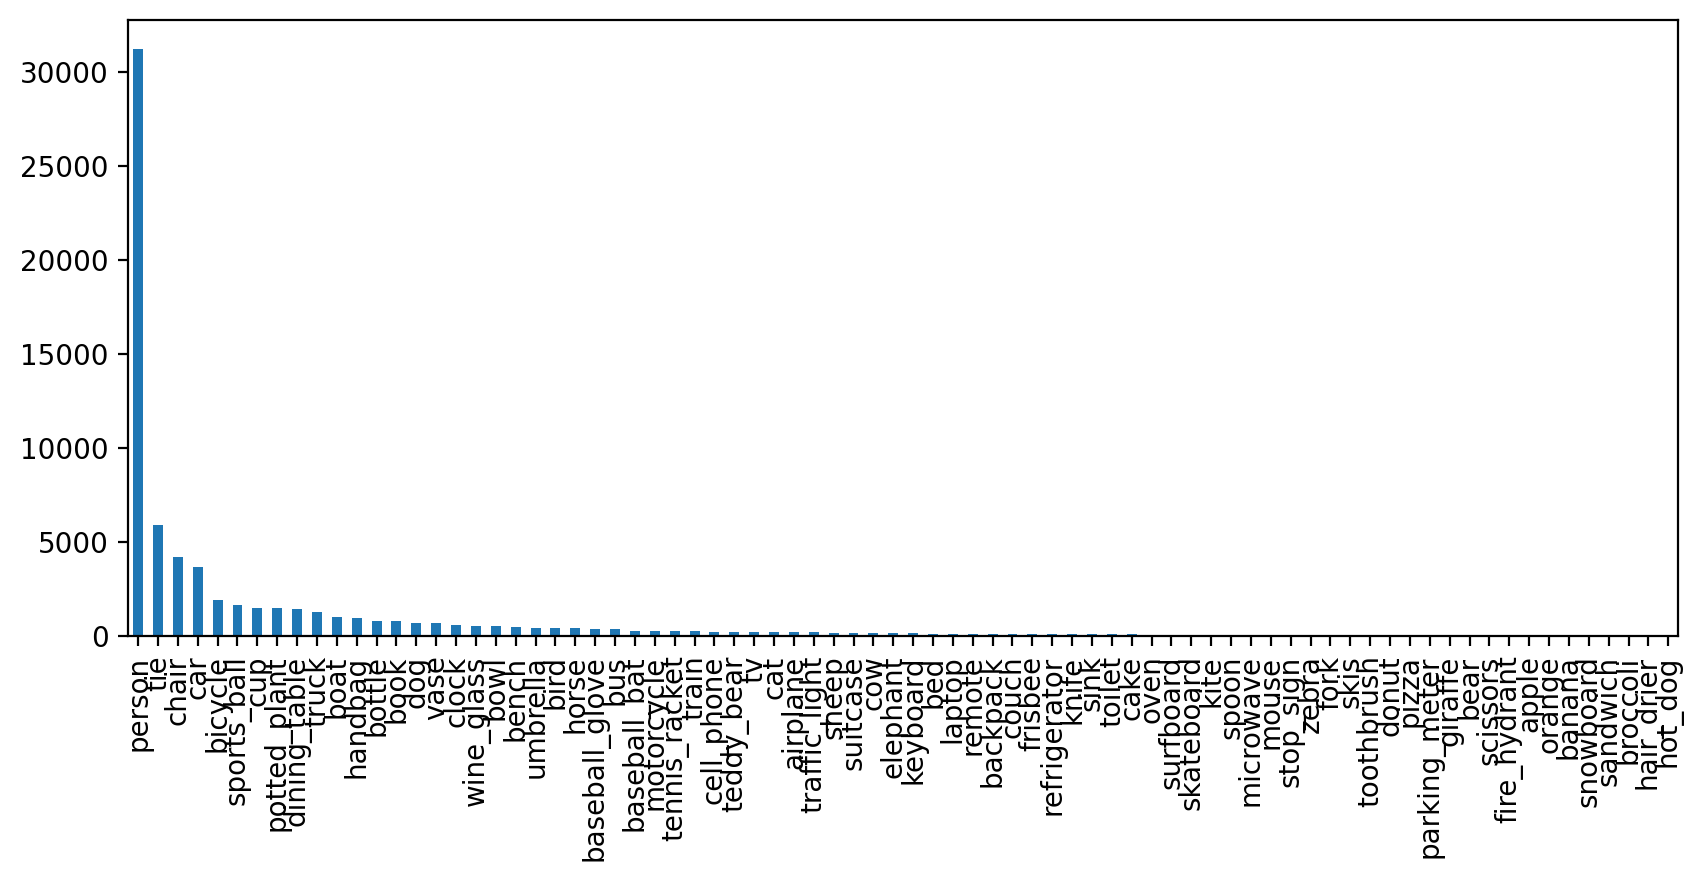

In [155]:
column_counts = encoded_df.eq(1).sum()
column_counts.sort_values(ascending=False).plot(kind='bar', figsize=(10,4))


In [157]:
# only select labels that occur more than 200 times
selected_labels = {k: v for k, v in column_counts.items() if v > 200}


In [12]:
# selected_columns = []
# for column in encoded_df.columns:
#     if column in selected_labels.keys():
#         selected_columns.append(column)
# result = ' + '.join(selected_columns)   

In [158]:
# only select labels that fit within these three categories, excluding sub-labels
transportation = ['bicycle', 'boat', 'bus', 'car', 'motorcycle', 'train', 'truck']
animals = ['bird', 'cat', 'dog', 'horse']
person = ['person']

selected_columns = transportation + animals + person

In [162]:
# print strings for easy copy-pasting into model definition, as f'string will not work

In [163]:
' + '.join(selected_columns)

'bicycle + boat + bus + car + motorcycle + train + truck + bird + cat + dog + horse + person'

In [164]:
', '.join(['"{}"'.format(item) for item in selected_columns])

'"bicycle", "boat", "bus", "car", "motorcycle", "train", "truck", "bird", "cat", "dog", "horse", "person"'

In [165]:
# I excluded random effects as they did not make a huge impact
# Also for plotting it was easier to exclude them as I couldn't figure out 
# how to show posterior predictions over random effects in Bambi/Arviz
# todo: figure this out

model = bmb.Model(f'error_bw_abs ~ 1 + bicycle + boat + bus + car + motorcycle + train + truck + bird + cat + dog + horse + person', 
                        df, 
                        family='zero_inflated_poisson')

In [166]:
# # Fit the model using 1000 on each of 4 chains
results = model.fit(draws=2500, chains=4, inference_method='nuts_numpyro')



Compiling...
Compilation time =  0:00:07.219566
Sampling...


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Sampling time =  0:02:15.949279
Transforming variables...
Transformation time =  0:00:00.032544


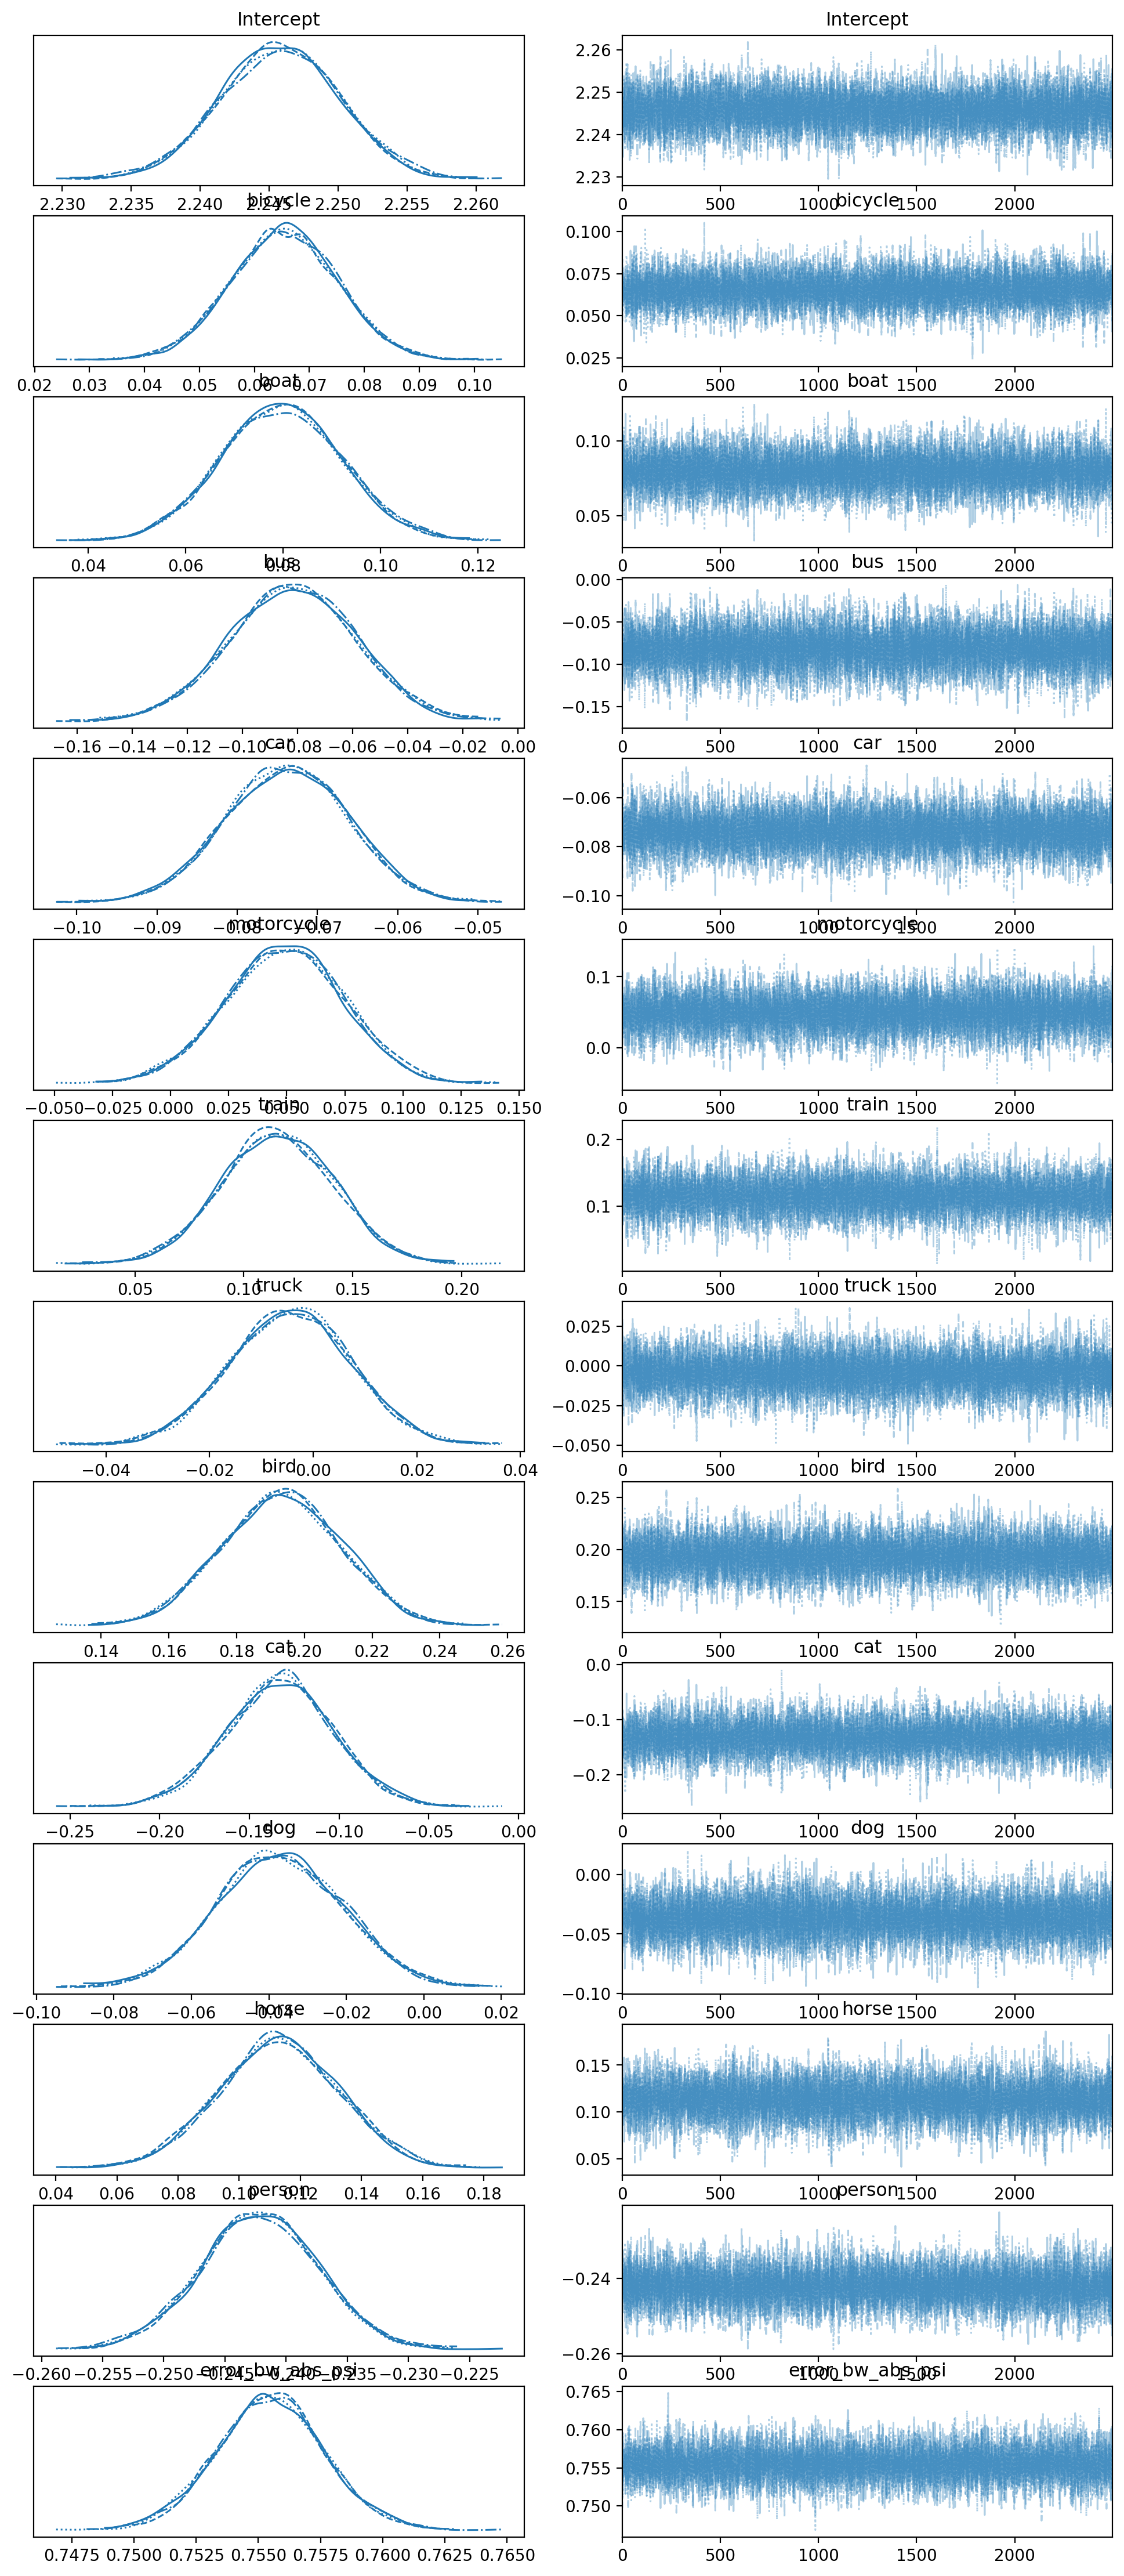

In [168]:
az.plot_trace(results);

In [170]:
az.summary(results)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept         2.246  0.004   2.238    2.254        0.0      0.0   17915.0   
bicycle[1]        0.065  0.010   0.048    0.084        0.0      0.0   19104.0   
boat[1]           0.080  0.012   0.055    0.102        0.0      0.0   20146.0   
bus[1]           -0.082  0.023  -0.126   -0.039        0.0      0.0   17066.0   
car[1]           -0.074  0.008  -0.089   -0.060        0.0      0.0   18109.0   
motorcycle[1]     0.049  0.025   0.003    0.097        0.0      0.0   17429.0   
train[1]          0.116  0.026   0.067    0.164        0.0      0.0   16485.0   
truck[1]         -0.004  0.012  -0.026    0.017        0.0      0.0   17280.0   
bird[1]           0.193  0.017   0.161    0.226        0.0      0.0   17003.0   
cat[1]           -0.133  0.030  -0.188   -0.076        0.0      0.0   15132.0   
dog[1]           -0.037  0.016  -0.069   -0.008        0.0      0.0   16838.0   
horse[1]          0.113  0.020   0.075    0.149        0.0      0.0   18826.0   
person[1]        -0.242  0.005  -0.251   -0.233        0.0      0.0   20656.0   
error_bw_abs_psi  0.755  0.002   0.751    0.759        0.0      0.0   18578.0   

                  ess_tail  r_hat  
Intercept           8483.0    1.0  
bicycle[1]          8014.0    1.0  
boat[1]             8028.0    1.0  
bus[1]              7900.0    1.0  
car[1]              7976.0    1.0  
motorcycle[1]       8435.0    1.0  
train[1]            7647.0    1.0  
truck[1]            7528.0    1.0  
bird[1]             7684.0    1.0  
cat[1]              6785.0    1.0  
dog[1]              7761.0    1.0  
horse[1]            8267.0    1.0  
person[1]           7964.0    1.0  
error_bw_abs_psi    7555.0    1.0

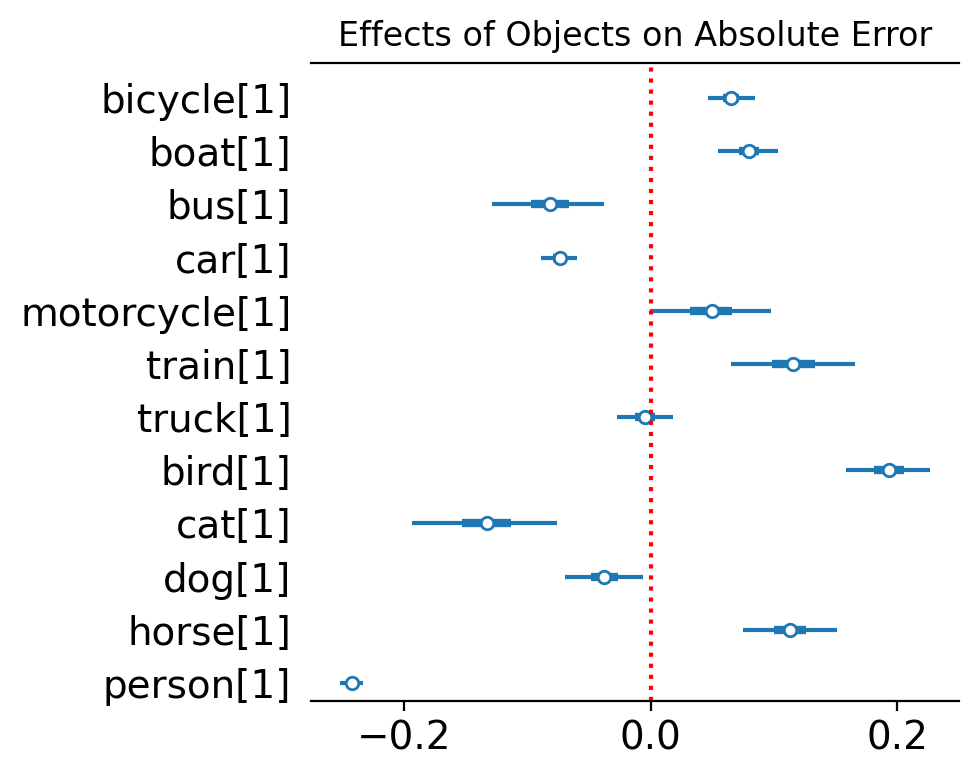

In [199]:
ax= az.plot_forest(
    results,
    combined=True,
    #filter_vars='like',
    #kind = 'ridgeplot',
    var_names = selected_columns,
    #var_names = ['person'],
    #var_names = ["bicycle", "boat", "boat", "bus", "car", "motorcycle", "train", "truck", "bird", "cat", "dog", "horse", "person"],
    figsize=(5, 4),
    hdi_prob=0.95,
);
ax[0].axvline(0, color="red", linestyle="dotted")
plt.title('Effects of Objects on Absolute Error')
plt.tight_layout()
plt.savefig('effects.png', dpi=300)

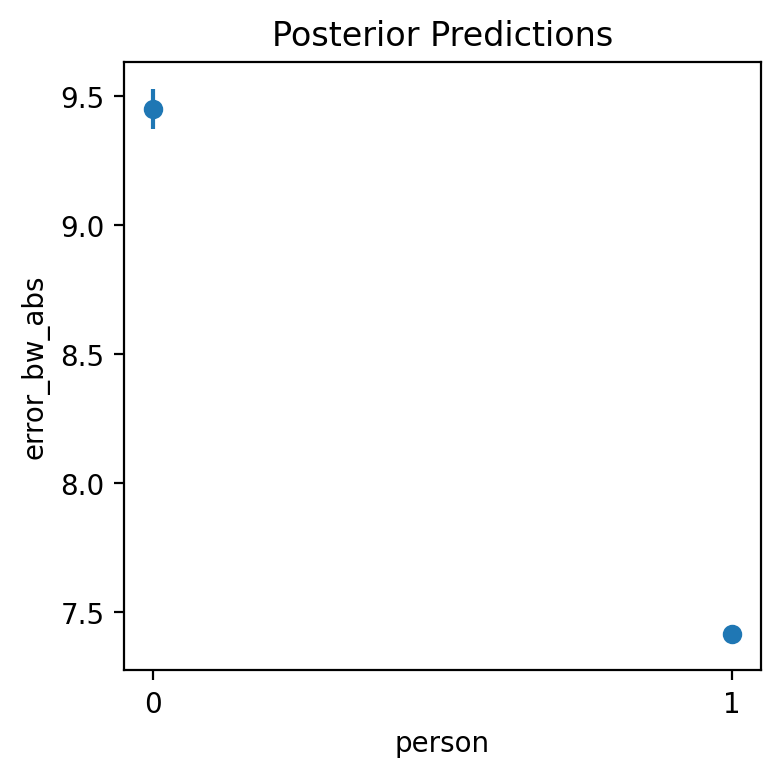

In [200]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_cap(model, results, ["person"], ax=ax);
plt.title('Posterior Predictions')
plt.tight_layout()
plt.savefig('predictions.png', dpi=300)